# Validation of method

### Table of contents

1. [**Schematic of models**](#schem)
2. [**Synthetic**](#syn)
3. [**Biophysical**](#bio)
4. [**Place cells regression**](#place)
5. [**Place cells comodulation**](#corr)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

import pickle


import sys

sys.path.append("../../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../../scripts/fit")

import template



import matplotlib.pyplot as plt
plt.style.use(['paper.mplstyle'])
#plt.rc('text', usetex=True)

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/scripts/plots/../../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)

double_arrays = False

if double_arrays:
    jax.config.update("jax_enable_x64", True)
    array_type = "float64"
else:
    array_type = "float32"

# seed everything
seed = 123
prng_state = jr.PRNGKey(seed)
rng = np.random.default_rng(seed)

In [51]:
import plot_BNPP_checks

datadir = '../saves/'
name = 'th1_regression'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)

tuning_dict, regression_dict = results["tuning"], results["regression"]
reg_config_names = list(regression_dict.keys())

syn_names = reg_config_names[-2:]



datadir = '../saves_/'
name = 'hc3_regression'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)


regression_dict = results["regression"]
tuning_dict = results["tuning"]


th1_names = [
    
]


hc3_names = [
    
]

<ErrorbarContainer object of 3 artists>

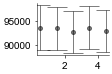

In [280]:
fig = plt.figure(figsize=(10, 4))



fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center', fontweight='bold')
plot_BNPP_checks.plot_BNPPs(fig)


fig.text(-0.05, 1.05, 'B', fontsize=15, ha='center', fontweight='bold')
plot_BNPP_checks.plot_BNPPs(fig)



plt.show()

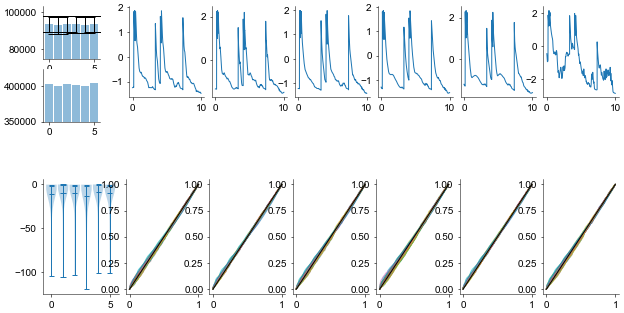

## th1

In [ ]:
import plot_real

In [ ]:
datadir = '../saves/'#saves_/'
# name = 'results_th1'
# results = pickle.load(
#     open(datadir + name + ".p", "rb")
# )
# regression_dict = results["regression"]
# tuning_dict = results["tuning"]
# variability_dict = results["variability"]

tuning_dict = pickle.load(
    open(datadir + 'th1_tuning' + ".p", "rb")
)

variability_dict = pickle.load(
    open(datadir + 'th1_variability' + ".p", "rb")
)

bnpp_dict = pickle.load(
    open(datadir + 'th1_regression' + ".p", "rb")
)

baseline_dict = pickle.load(
    open(datadir + 'th1_baselines' + ".p", "rb")
)

regression_dict = {**baseline_dict, **bnpp_dict}
reg_config_names = list(regression_dict.keys())
    
    
plot_units = [5, 27]

In [ ]:
names = list(baseline_dict.keys())

train_loss = []
for n in names:
    train_loss.append(baseline_dict[n]["train_ell"])

In [ ]:
plt.scatter(np.arange(len(names)), train_loss, marker='+', s=40)
plt.gca().set_xticks(np.arange(len(names)))
plt.gca().set_xticklabels(names, rotation=90)

plt.show()

In [14]:
cs = [
    'tab:blue',
    'tab:orange', 
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:gray',
]
use_model_inds = np.array([0, 1, 2, 3, 4, 5, 9])
use_reg_config_names = [reg_config_names[k] for k in use_model_inds]
use_names = [
    'Poisson', 
    'gamma', 
    'log normal', 
    'inverse \nGaussian', 
    'conditional \nPoisson', 
    'conditional \nlog normal', 
    'NP (ours)', 
]
visualize_inds = [0, 2, 4, 5, 6]
visualize_names = [reg_config_names[k] for k in use_model_inds[visualize_inds]]

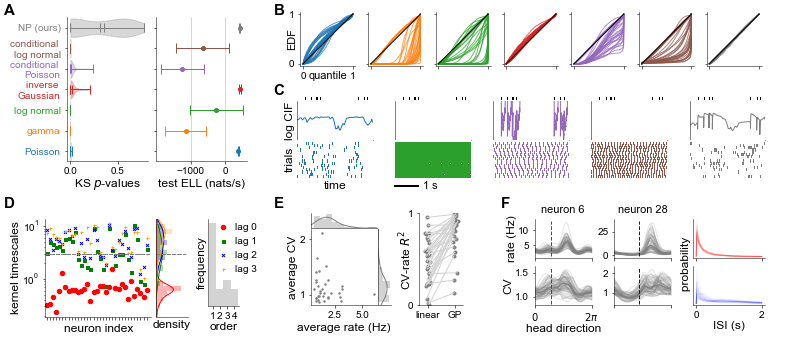

In [15]:
fig = plt.figure(figsize=(10, 4))
fig.set_facecolor('white')

  
fig.text(-0.05, 1.01, 'A', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_fit_stats(fig, 0., 0., regression_dict, use_reg_config_names, use_names, cs)

fig.text(0.325, 1.01, 'B', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_QQ(fig, 0., 0.02, regression_dict, use_reg_config_names, cs)

fig.text(0.325, 0.73, 'C', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_posteriors(fig, 0., 0., regression_dict, visualize_names, visualize_inds, cs)

fig.text(-0.05, 0.34, 'D', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_kernel_lens(fig, 0., 0., tuning_dict)

fig.text(0.325, 0.34, 'E', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_instantaneous(fig, 0., 0., rng, variability_dict, plot_units)

fig.text(0.62, 0.34, 'F', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_th1_tuning(fig, 0., 0., tuning_dict, plot_units)

fig.text(1.02, 1.01, 'S', fontsize=15, alpha=0., ha='center')  # space


    

#plt.savefig('../saves/th1.pdf')
plt.show()

In [6]:
import plot_real_details

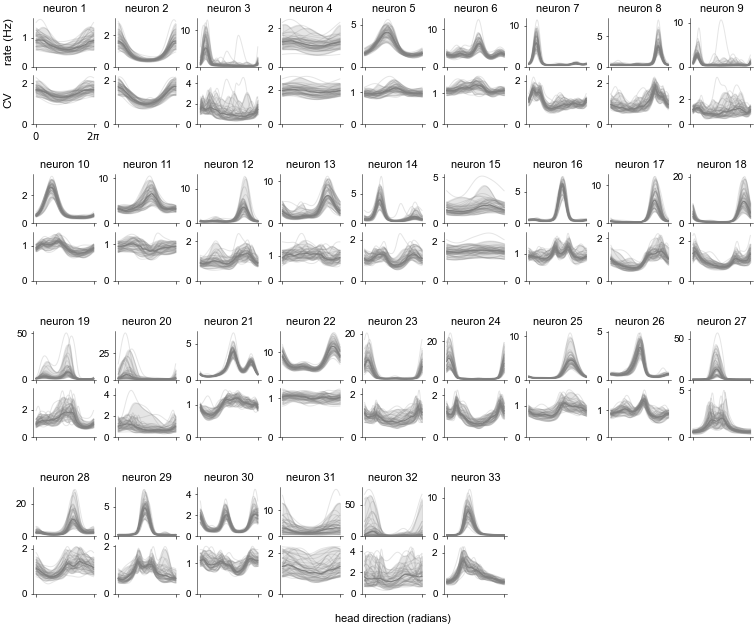

In [175]:
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')

plot_real_details.plot_th1_tuning(fig, tuning_dict)


plt.savefig('../saves/th1_tuning.pdf')
plt.show()

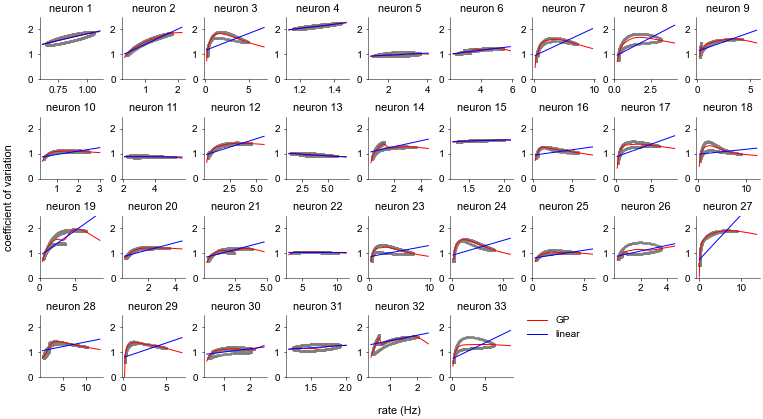

In [8]:
fig = plt.figure(figsize=(10, 5))
fig.set_facecolor('white')

plot_real_details.plot_instantaneous(fig, variability_dict)


plt.savefig('../saves/th1_variability.png', dpi=100)
plt.show()

## hc3

In [3]:
datadir = '../saves/'

tuning_dict = pickle.load(
    open(datadir + 'hc3_tuning' + ".p", "rb")
)

variability_dict = pickle.load(
    open(datadir + 'hc3_variability' + ".p", "rb")
)

# bnpp_dict = pickle.load(
#     open(datadir + 'hc3_regression' + ".p", "rb")
# )

baseline_dict = pickle.load(
    open(datadir + 'hc3_baselines' + ".p", "rb")
)

regression_dict = {**baseline_dict, **bnpp_dict}
reg_config_names = list(regression_dict.keys())

    
plot_units = [5, 27]

NameError: name 'bnpp_dict' is not defined

In [4]:
names = list(baseline_dict.keys())

train_loss = []
for n in names:
    train_loss.append(baseline_dict[n]["train_ell"])

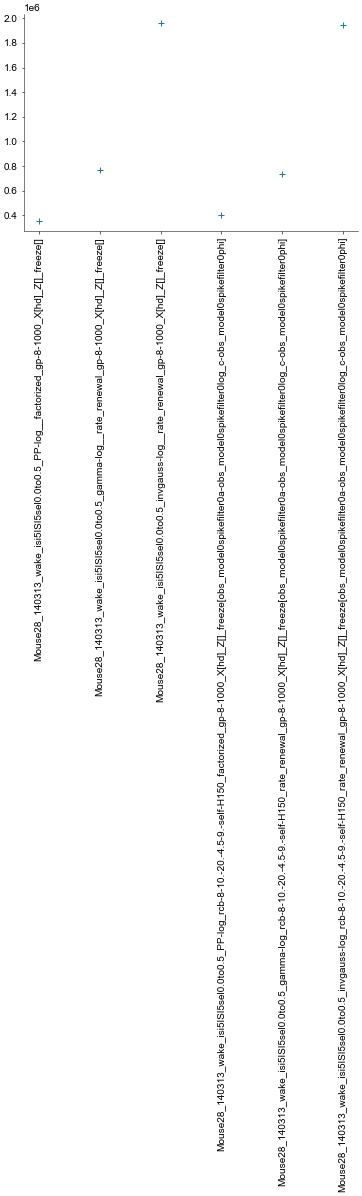

In [40]:
plt.scatter(np.arange(len(names)), train_loss, marker='+', s=40)
plt.gca().set_xticks(np.arange(len(names)))
plt.gca().set_xticklabels(names, rotation=90)

plt.show()

In [14]:
import plot_real_details

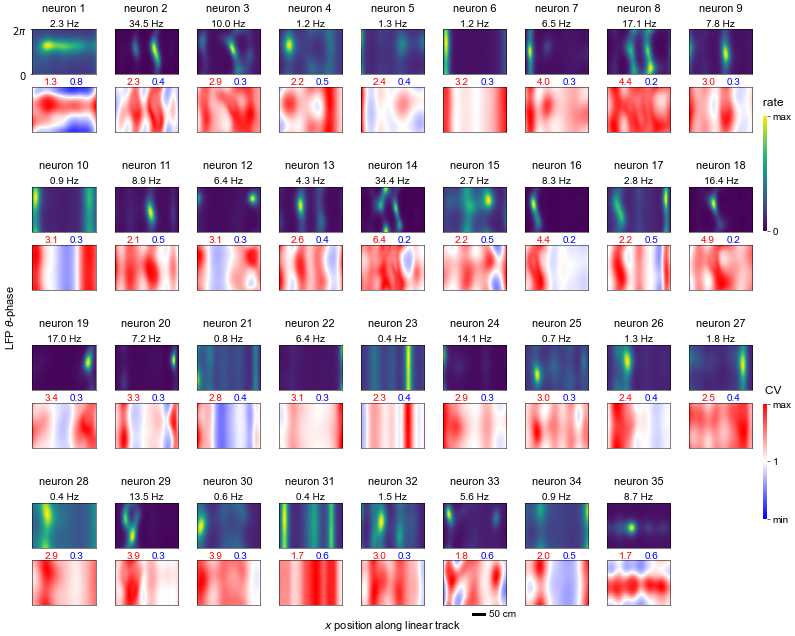

In [17]:
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')

direction = "LR"

plot_real_details.plot_hc3_tuning(fig, tuning_dict, direction)


plt.savefig('../saves/hc3_LR_tuning.pdf')
plt.show()

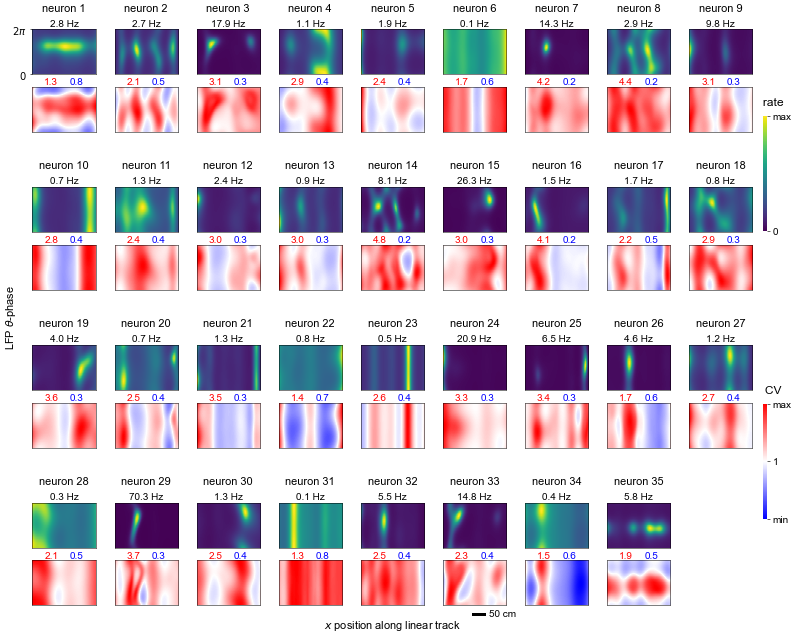

In [18]:
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')

direction = "RL"

plot_real_details.plot_hc3_tuning(fig, tuning_dict, direction)


plt.savefig('../saves/hc3_RL_tuning.pdf')
plt.show()

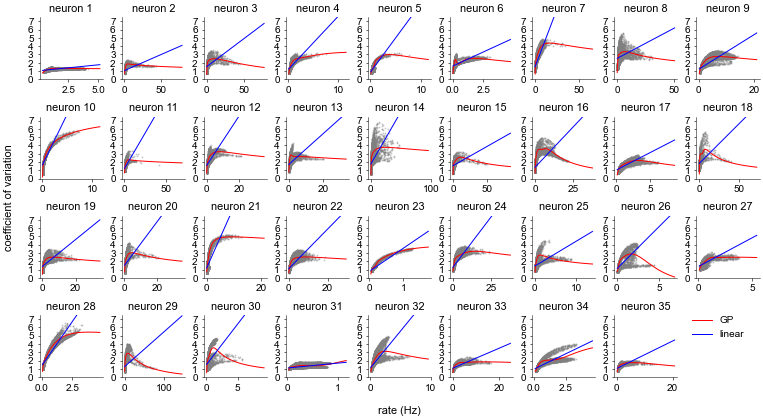

In [10]:
fig = plt.figure(figsize=(10, 5))
fig.set_facecolor('white')

plot_real_details.plot_instantaneous(fig, variability_dict)


plt.savefig('../saves/hc3_variability.png', dpi=100)
plt.show()

In [5]:
cs = [
    'tab:blue',
    'tab:orange', 
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:gray',
]
use_model_inds = np.array([0, 1, 2, 3, 4, 5, 9])
use_reg_config_names = [reg_config_names[k] for k in use_model_inds]
use_names = [
    'Poisson', 
    'gamma', 
 #   'log normal', 
    'inverse \nGaussian', 
    'cond. P', 
    'cond. G', 
    'cond. IG', 
    'NP (ours)', 
]
visualize_inds = [0, 2, 4, 5]
visualize_names = [reg_config_names[k] for k in use_model_inds[visualize_inds]]


NameError: name 'reg_config_names' is not defined

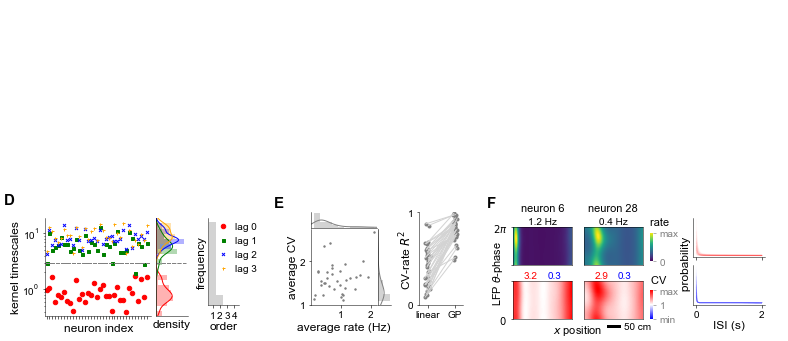

In [32]:
fig = plt.figure(figsize=(10, 4))
fig.set_facecolor('white')


    

fig.text(-0.05, 1.01, 'A', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_fit_stats(fig, 0., 0., regression_dict, use_reg_config_names, use_names, cs)

fig.text(0.325, 1.01, 'B', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_QQ(fig, 0., 0.02, regression_dict, use_reg_config_names, cs)

fig.text(0.325, 0.72, 'C', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_posteriors(fig, 0., 0., regression_dict, visualize_names, visualize_inds, cs)

fig.text(-0.05, 0.35, 'D', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_kernel_lens(fig, 0., 0., tuning_dict)

fig.text(0.325, 0.34, 'E', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_instantaneous(fig, 0., 0., rng, variability_dict, plot_units)

fig.text(0.62, 0.34, 'F', fontsize=15, ha='center', fontweight='bold')
plot_real.plot_hc3_tuning(fig, 0., 0., tuning_dict, "LR", plot_units)

fig.text(1.02, 1.01, 'S', fontsize=15, alpha=0., ha='center')  # space
    

    

#plt.savefig('../saves/hc3.pdf')
plt.show()